copied and edited from:\
https://github.com/tkwoo/anogan-keras/blob/master/anogan.py

copied edited from:\
https://github.com/yjucho1/anoGAN

In [5]:
import os

os.getcwd()

'/content'

In [0]:
from __future__ import print_function
from keras.models import Sequential, Model
from keras.layers import Input, Reshape, Dense, Dropout, MaxPooling2D, Conv2D, Flatten
from keras.layers import Conv2DTranspose, LeakyReLU
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras import backend as K
from keras import initializers
import tensorflow as tf
import numpy as np
from tqdm import tqdm
import cv2
import math

from keras.utils. generic_utils import Progbar

### combine images for visualization
def combine_images(generated_images):
    num = generated_images.shape[0]
    width = int(math.sqrt(num))
    height = int(math.ceil(float(num)/width))
    shape = generated_images.shape[1:4]
    image = np.zeros((height*shape[0], width*shape[1], shape[2]),
                     dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1],:] = img[:, :, :]
    return image

### generator model define
def generator_model():
    inputs = Input((10,))
    fc1 = Dense(input_dim=10, units=128*7*7)(inputs)
    fc1 = BatchNormalization()(fc1)
    fc1 = LeakyReLU(0.2)(fc1)
    fc2 = Reshape((7, 7, 128), input_shape=(128*7*7,))(fc1)
    up1 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(fc2)
    conv1 = Conv2D(64, (3, 3), padding='same')(up1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    up2 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv1)
    conv2 = Conv2D(1, (5, 5), padding='same')(up2)
    outputs = Activation('tanh')(conv2)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

### discriminator model define
def discriminator_model():
    inputs = Input((28, 28, 1))
    conv1 = Conv2D(64, (5, 5), padding='same')(inputs)
    conv1 = LeakyReLU(0.2)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, (5, 5), padding='same')(pool1)
    conv2 = LeakyReLU(0.2)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    fc1 = Flatten()(pool2)
    fc1 = Dense(1)(fc1)
    outputs = Activation('sigmoid')(fc1)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

### d_on_g model for training generator
def generator_containing_discriminator(g, d):
    d.trainable = False
    ganInput = Input(shape=(10,))
    x = g(ganInput)
    ganOutput = d(x)
    gan = Model(inputs=ganInput, outputs=ganOutput)
    # gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan

def load_model():
    d = discriminator_model()
    g = generator_model()
    d_optim = RMSprop()
    g_optim = RMSprop(lr=0.0002)
    g.compile(loss='binary_crossentropy', optimizer=g_optim)
    d.compile(loss='binary_crossentropy', optimizer=d_optim)
    d.load_weights('./weights/discriminator.h5')
    g.load_weights('./weights/generator.h5')
    return g, d

### train generator and discriminator
def train(BATCH_SIZE, X_train):
    
    ### model define
    d = discriminator_model()
    g = generator_model()
    d_on_g = generator_containing_discriminator(g, d)
    d_optim = RMSprop(lr=0.0004)
    g_optim = RMSprop(lr=0.0002)
    g.compile(loss='mse', optimizer=g_optim)
    d_on_g.compile(loss='mse', optimizer=g_optim)
    d.trainable = True
    d.compile(loss='mse', optimizer=d_optim)
    

    for epoch in range(10):
        print ("Epoch is", epoch)
        n_iter = int(X_train.shape[0]/BATCH_SIZE)
        progress_bar = Progbar(target=n_iter)
        
        for index in range(n_iter):
            # create random noise -> U(0,1) 10 latent vectors
            noise = np.random.uniform(0, 1, size=(BATCH_SIZE, 10))

            # load real data & generate fake data
            image_batch = X_train[index*BATCH_SIZE:(index+1)*BATCH_SIZE]
            generated_images = g.predict(noise, verbose=0)
            
            # visualize training results
            if index % 20 == 0:
                image = combine_images(generated_images)
                image = image*127.5+127.5
                cv2.imwrite('./result/'+str(epoch)+"_"+str(index)+".png", image)

            # attach label for training discriminator
            X = np.concatenate((image_batch, generated_images))
            y = np.array([1] * BATCH_SIZE + [0] * BATCH_SIZE)
            
            # training discriminator
            d_loss = d.train_on_batch(X, y)

            # training generator
            d.trainable = False
            g_loss = d_on_g.train_on_batch(noise, np.array([1] * BATCH_SIZE))
            d.trainable = True

            progress_bar.update(index, values=[('g',g_loss), ('d',d_loss)])
        print ('')

        # save weights for each epoch
        g.save_weights('./weights/generator/generator.h5', True)
        d.save_weights('./weights/discriminator/discriminator.h5', True)
    return d, g

### generate images
def generate(BATCH_SIZE):
    g = generator_model()
    g.load_weights('./weights/generator/generator.h5')
    noise = np.random.uniform(0, 1, (BATCH_SIZE, 10))
    generated_images = g.predict(noise)
    return generated_images

### anomaly loss function 
def sum_of_residual(y_true, y_pred):
    return K.sum(K.abs(y_true - y_pred))

### discriminator intermediate layer feautre extraction
def feature_extractor(d=None):
    if d is None:
        d = discriminator_model()
        d.load_weights('./weights/discriminator/discriminator.h5') 
    intermidiate_model = Model(inputs=d.layers[0].input, outputs=d.layers[-7].output)
    intermidiate_model.compile(loss='binary_crossentropy', optimizer='rmsprop')
    return intermidiate_model

### anomaly detection model define
def anomaly_detector(g=None, d=None):
    if g is None:
        g = generator_model()
        g.load_weights('./weights/generator/generator.h5')
    intermidiate_model = feature_extractor(d)
    intermidiate_model.trainable = False
    g = Model(inputs=g.layers[1].input, outputs=g.layers[-1].output)
    g.trainable = False
    # Input layer cann't be trained. Add new layer as same size & same distribution
    aInput = Input(shape=(10,))
    gInput = Dense((10), trainable=True)(aInput)
    gInput = Activation('sigmoid')(gInput)
    
    # G & D feature
    G_out = g(gInput)
    D_out= intermidiate_model(G_out)    
    model = Model(inputs=aInput, outputs=[G_out, D_out])
    model.compile(loss=sum_of_residual, loss_weights= [0.90, 0.10], optimizer='rmsprop')
    
    # batchnorm learning phase fixed (test) : make non trainable
    K.set_learning_phase(0)
    
    return model

### anomaly detection
def compute_anomaly_score(model, x, iterations=500, d=None):
    z = np.random.uniform(0, 1, size=(1, 10))
    
    intermidiate_model = feature_extractor(d)
    d_x = intermidiate_model.predict(x)

    # learning for changing latent
    loss = model.fit(z, [x, d_x], batch_size=1, epochs=iterations, verbose=0)
    similar_data, _ = model.predict(z)
    
    loss = loss.history['loss'][-1]
    
    return loss, similar_data

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from tqdm import tqdm
# import anogan

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.astype(np.float32)/255.
X_train = X_train.reshape(60000, 28, 28, 1)


# Model_d, Model_g = anogan.train(32, X_train)
Model_d, Model_g = train(32, X_train)

Epoch is 0
1872/1875 [============================>.] - ETA: 0s - g: 0.3833 - d: 0.0289
Epoch is 1
1873/1875 [============================>.] - ETA: 0s - g: 0.4813 - d: 0.0272
Epoch is 2
1872/1875 [============================>.] - ETA: 0s - g: 0.4376 - d: 0.0286
Epoch is 3
1874/1875 [============================>.] - ETA: 0s - g: 0.4750 - d: 0.0266
Epoch is 4
1871/1875 [============================>.] - ETA: 0s - g: 0.5700 - d: 0.0376
Epoch is 5
1874/1875 [============================>.] - ETA: 0s - g: 0.6031 - d: 0.0391
Epoch is 6
1871/1875 [============================>.] - ETA: 0s - g: 0.6458 - d: 0.0434
Epoch is 7
1871/1875 [============================>.] - ETA: 0s - g: 0.7036 - d: 0.0461
Epoch is 8
1872/1875 [============================>.] - ETA: 0s - g: 0.7199 - d: 0.0466
Epoch is 9
1874/1875 [============================>.] - ETA: 0s - g: 0.7503 - d: 0.0487


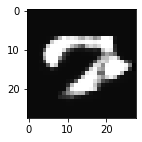

In [24]:
## generate random image 

generated_img = generate(3)
plt.figure(figsize=(2, 2))
plt.imshow(generated_img[0].reshape(28, 28),cmap=plt.cm.gray)
plt.show()

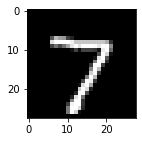

anomaly score : 48.72065353393555


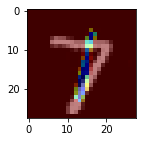

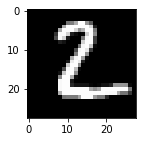

anomaly score : 33.766090393066406


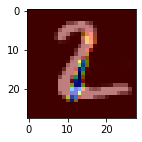

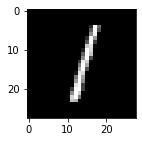

anomaly score : 37.129554748535156


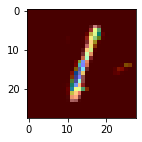

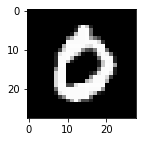

anomaly score : 44.493934631347656


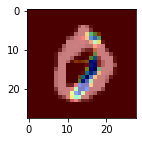

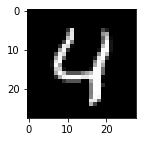

anomaly score : 39.266746520996094


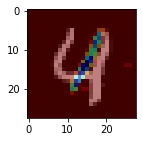

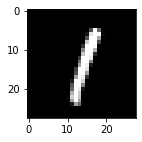

anomaly score : 34.253517150878906


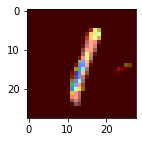

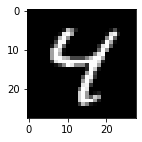

anomaly score : 33.80790710449219


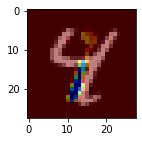

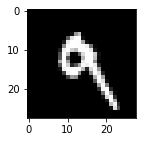

anomaly score : 34.027008056640625


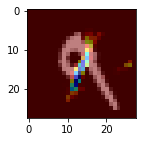

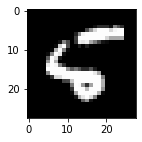

anomaly score : 42.92216491699219


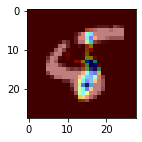

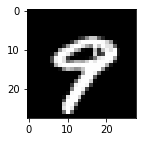

anomaly score : 45.573692321777344


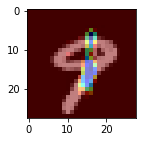

In [43]:
## compute anomaly score - sample from test set

X_test = X_test.astype(np.float32)/255.
X_test = X_test.reshape(-1, 28, 28, 1)

for i in range(10):
  test_img = X_test[i]
  
  model = anomaly_detector()
  ano_score, similar_img = compute_anomaly_score(model, test_img.reshape(1, 28, 28, 1))
  
  plt.figure(figsize=(2, 2))
  plt.imshow(test_img.reshape(28,28), cmap=plt.cm.gray)
  plt.show()
  print("anomaly score : " + str(ano_score))
  
  plt.figure(figsize=(2, 2))
  plt.imshow(test_img.reshape(28,28), cmap=plt.cm.gray)
  residual  = test_img.reshape(28,28) - similar_img.reshape(28, 28)
  plt.imshow(residual, cmap='jet', alpha=.5)
  plt.show()

# test_img = X_test[0]

# model = anomaly_detector()
# ano_score, similar_img = compute_anomaly_score(model, test_img.reshape(1, 28, 28, 1))

# plt.figure(figsize=(2, 2))
# plt.imshow(test_img.reshape(28,28), cmap=plt.cm.gray)
# plt.show()
# print("anomaly score : " + str(ano_score))
# plt.figure(figsize=(2, 2))
# plt.imshow(test_img.reshape(28,28), cmap=plt.cm.gray)
# residual  = test_img.reshape(28,28) - similar_img.reshape(28, 28)
# plt.imshow(residual, cmap='jet', alpha=.5)
# plt.show()
## plt.savefig('assets/test_img.png')

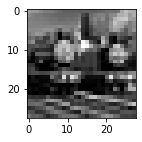

anomaly score : 310.8585205078125


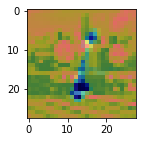

In [26]:
## compute anomaly score - sample from strange image

test_img = plt.imread('assets/test_img.png')
test_img = test_img[:,:,0]

model = anomaly_detector()
ano_score, similar_img = compute_anomaly_score(model, test_img.reshape(1, 28, 28, 1))

plt.figure(figsize=(2, 2))
plt.imshow(test_img.reshape(28,28), cmap=plt.cm.gray)
plt.show()
print("anomaly score : " + str(ano_score))
plt.figure(figsize=(2, 2))
plt.imshow(test_img.reshape(28,28), cmap=plt.cm.gray)
residual  = test_img.reshape(28,28) - similar_img.reshape(28, 28)
plt.imshow(residual, cmap='jet', alpha=.5)
plt.show()

a sample from generated anomaly images(random noise image)


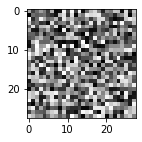

300/300 [==============================] - 0s 130us/step


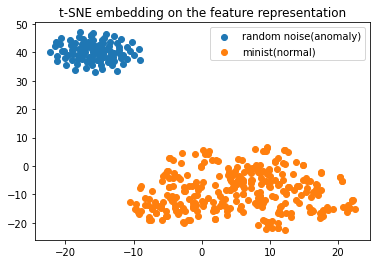

In [22]:
from sklearn.manifold import TSNE

## t-SNE embedding 

# generating anomaly image for test (radom noise image)

random_image = np.random.uniform(0,1, (100, 28,28, 1))
print("a sample from generated anomaly images(random noise image)")
plt.figure(figsize=(2, 2))
plt.imshow(random_image[0].reshape(28,28), cmap=plt.cm.gray)
plt.show()

# intermidieate output of discriminator
model = feature_extractor()
feature_map_of_random = model.predict(random_image, verbose=1)
feature_map_of_minist = model.predict(X_test[:300], verbose=1)

# t-SNE for visulization
output = np.concatenate((feature_map_of_random, feature_map_of_minist))
output = output.reshape(output.shape[0], -1)
anomaly_flag = np.array([1]*100+ [0]*300)

X_embedded = TSNE(n_components=2).fit_transform(output)
plt.title("t-SNE embedding on the feature representation")
plt.scatter(X_embedded[:100,0], X_embedded[:100,1], label='random noise(anomaly)')
plt.scatter(X_embedded[100:,0], X_embedded[100:,1], label='minist(normal)')
plt.legend()
plt.show()

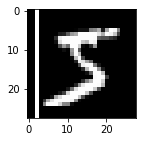

anomaly score : 138.23468017578125


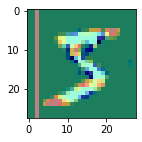

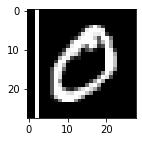

anomaly score : 112.90274047851562


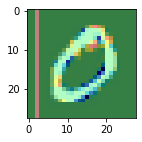

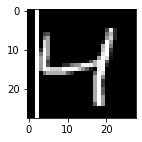

anomaly score : 193.4071044921875


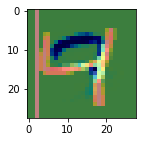

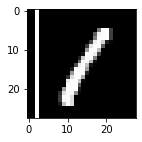

anomaly score : 83.69718170166016


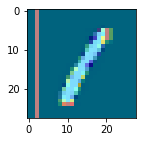

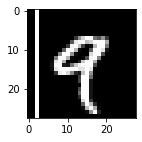

anomaly score : 106.07286834716797


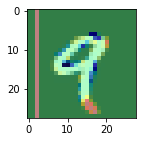

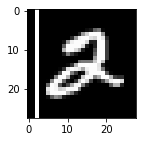

anomaly score : 158.4058837890625


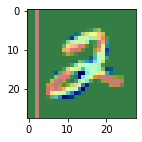

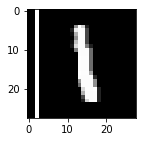

anomaly score : 98.98049926757812


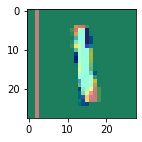

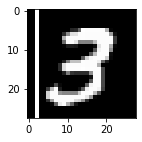

anomaly score : 114.06123352050781


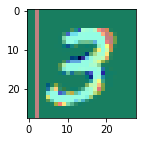

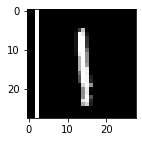

anomaly score : 84.83422088623047


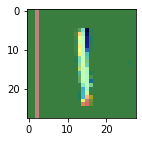

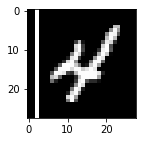

anomaly score : 135.56594848632812


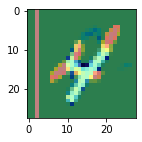

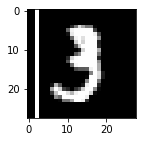

anomaly score : 133.329345703125


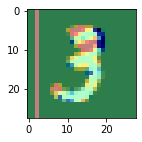

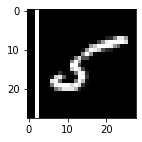

anomaly score : 147.17845153808594


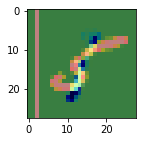

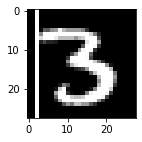

anomaly score : 140.7200927734375


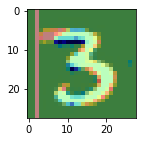

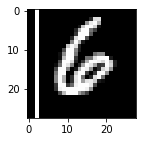

anomaly score : 160.92822265625


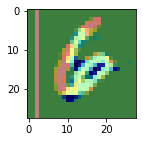

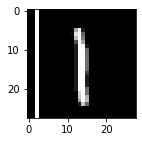

anomaly score : 99.1633529663086


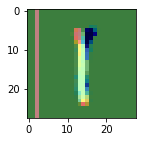

In [45]:
from keras.models import load_model
from sklearn.manifold import TSNE
import numpy as np


# load test data
(trainX, _), (_, _) = mnist.load_data()

# expand to 3d, e.g. add channels dimension
X = np.expand_dims(trainX, axis=-1)

# convert from unsigned ints to floats
X = X.astype('float32') / 255


for i in range(15):
  X_anomal = X[i]
  X_anomal[:, 2, :] = 1.
  X_anomal = X_anomal.reshape(1, 28, 28, 1)
  
  ## compute anomaly score - sample from strange image
  model = anomaly_detector()
  ano_score, similar_img = compute_anomaly_score(model, X_anomal.reshape(1, 28, 28, 1))
  plt.figure(figsize=(2, 2))
  plt.imshow(X_anomal.reshape(28,28), cmap=plt.cm.gray)
  plt.show()
  print("anomaly score : " + str(ano_score))
  
  plt.figure(figsize=(2, 2))
  plt.imshow(X_anomal.reshape(28,28), cmap=plt.cm.gray)
  residual  = X_anomal.reshape(28,28) - similar_img.reshape(28, 28)
  plt.imshow(residual, cmap='jet', alpha=.5)
  plt.show()

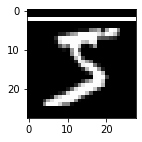

anomaly score : 133.64633178710938


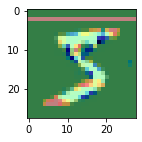

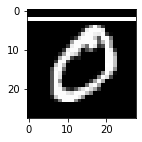

anomaly score : 108.36763763427734


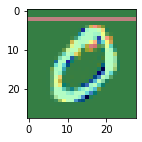

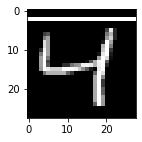

anomaly score : 191.98687744140625


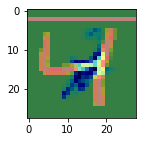

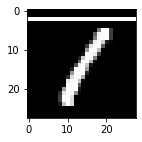

anomaly score : 81.86186981201172


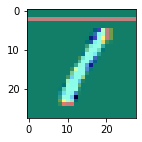

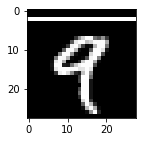

anomaly score : 103.57449340820312


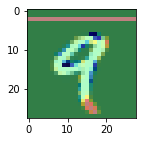

In [47]:
from keras.models import load_model
from sklearn.manifold import TSNE
import numpy as np


# load test data
(trainX, _), (_, _) = mnist.load_data()

# expand to 3d, e.g. add channels dimension
X = np.expand_dims(trainX, axis=-1)

# convert from unsigned ints to floats
X = X.astype('float32') / 255


for i in range(5):
  X_anomal = X[i]
  X_anomal[2, :, :] = 1.
  X_anomal = X_anomal.reshape(1, 28, 28, 1)
  
  ## compute anomaly score - sample from strange image
  model = anomaly_detector()
  ano_score, similar_img = compute_anomaly_score(model, X_anomal.reshape(1, 28, 28, 1))
  plt.figure(figsize=(2, 2))
  plt.imshow(X_anomal.reshape(28,28), cmap=plt.cm.gray)
  plt.show()
  print("anomaly score : " + str(ano_score))
  
  plt.figure(figsize=(2, 2))
  plt.imshow(X_anomal.reshape(28,28), cmap=plt.cm.gray)
  residual  = X_anomal.reshape(28,28) - similar_img.reshape(28, 28)
  plt.imshow(residual, cmap='jet', alpha=.5)
  plt.show()

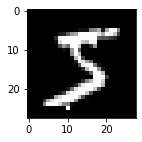

anomaly score : 89.2442626953125


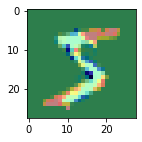

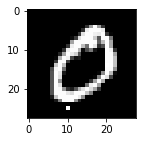

anomaly score : 58.753074645996094


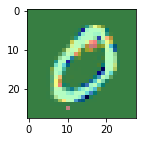

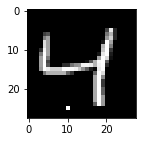

anomaly score : 134.2138671875


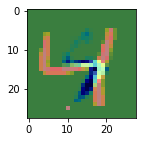

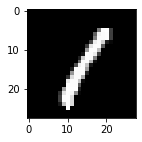

anomaly score : 29.57452392578125


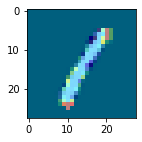

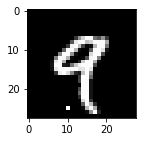

anomaly score : 55.17460632324219


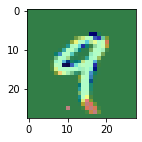

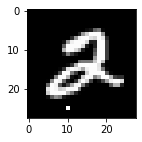

anomaly score : 116.69518280029297


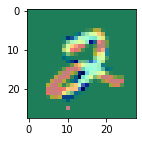

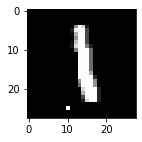

anomaly score : 85.92001342773438


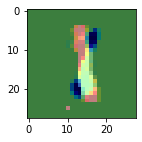

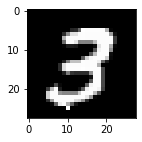

anomaly score : 89.16775512695312


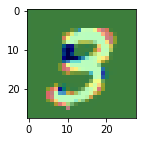

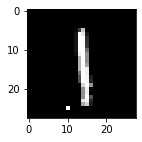

anomaly score : 35.5880241394043


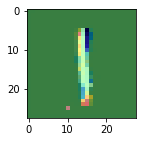

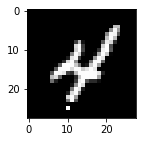

anomaly score : 79.72116088867188


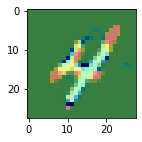

In [55]:
from keras.models import load_model
from sklearn.manifold import TSNE
import numpy as np


# load test data
(trainX, _), (_, _) = mnist.load_data()

# expand to 3d, e.g. add channels dimension
X = np.expand_dims(trainX, axis=-1)

# convert from unsigned ints to floats
X = X.astype('float32') / 255


for i in range(10):
  X_anomal = X[i]
  X_anomal[25, 10, :] = 1.
  X_anomal = X_anomal.reshape(1, 28, 28, 1)
  
  ## compute anomaly score - sample from strange image
  model = anomaly_detector()
  ano_score, similar_img = compute_anomaly_score(model, X_anomal.reshape(1, 28, 28, 1))
  plt.figure(figsize=(2, 2))
  plt.imshow(X_anomal.reshape(28,28), cmap=plt.cm.gray)
  plt.show()
  print("anomaly score : " + str(ano_score))
  
  plt.figure(figsize=(2, 2))
  plt.imshow(X_anomal.reshape(28,28), cmap=plt.cm.gray)
  residual  = X_anomal.reshape(28,28) - similar_img.reshape(28, 28)
  plt.imshow(residual, cmap='jet', alpha=.5)
  plt.show()

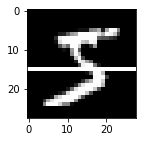

anomaly score : 122.77832794189453


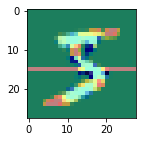

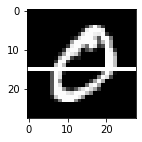

anomaly score : 95.68193054199219


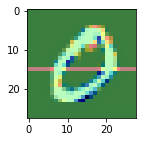

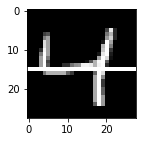

anomaly score : 141.6671142578125


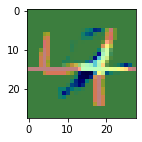

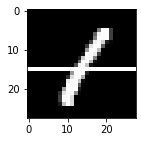

anomaly score : 70.50405883789062


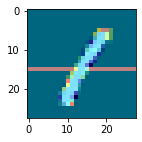

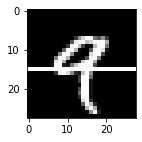

anomaly score : 74.06178283691406


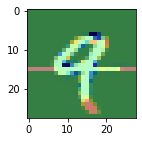

In [57]:
from keras.models import load_model
from sklearn.manifold import TSNE
import numpy as np


# load test data
(trainX, _), (_, _) = mnist.load_data()

# expand to 3d, e.g. add channels dimension
X = np.expand_dims(trainX, axis=-1)

# convert from unsigned ints to floats
X = X.astype('float32') / 255


for i in range(5):
  X_anomal = X[i]
  X_anomal[15, :, :] = 1.
  X_anomal = X_anomal.reshape(1, 28, 28, 1)
  
  ## compute anomaly score - sample from strange image
  model = anomaly_detector()
  ano_score, similar_img = compute_anomaly_score(model, X_anomal.reshape(1, 28, 28, 1))
  plt.figure(figsize=(2, 2))
  plt.imshow(X_anomal.reshape(28,28), cmap=plt.cm.gray)
  plt.show()
  print("anomaly score : " + str(ano_score))
  
  plt.figure(figsize=(2, 2))
  plt.imshow(X_anomal.reshape(28,28), cmap=plt.cm.gray)
  residual  = X_anomal.reshape(28,28) - similar_img.reshape(28, 28)
  plt.imshow(residual, cmap='jet', alpha=.5)
  plt.show()

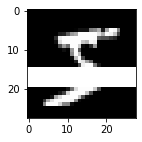

anomaly score : 184.85623168945312


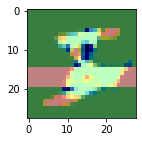

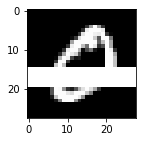

anomaly score : 189.786376953125


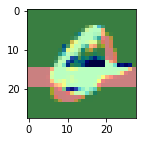

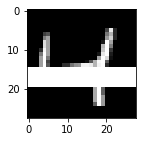

anomaly score : 204.99453735351562


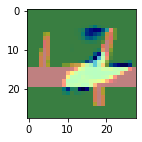

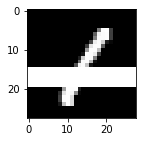

anomaly score : 182.9134521484375


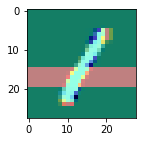

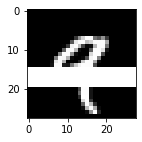

anomaly score : 184.74795532226562


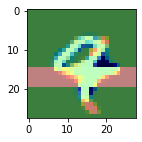

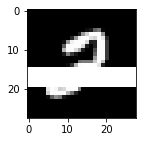

anomaly score : 135.44970703125


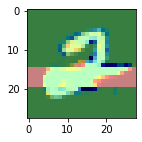

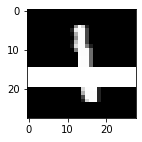

anomaly score : 179.48092651367188


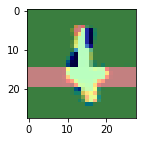

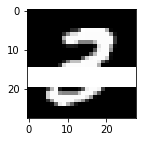

anomaly score : 171.3638153076172


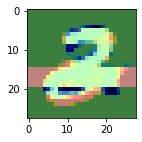

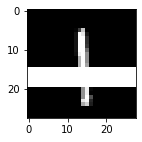

anomaly score : 167.096435546875


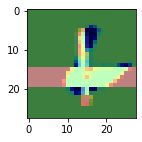

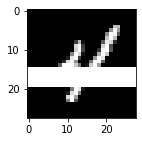

anomaly score : 188.79129028320312


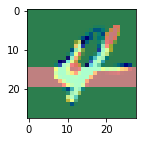

In [59]:
from keras.models import load_model
from sklearn.manifold import TSNE
import numpy as np


# load test data
(trainX, _), (_, _) = mnist.load_data()

# expand to 3d, e.g. add channels dimension
X = np.expand_dims(trainX, axis=-1)

# convert from unsigned ints to floats
X = X.astype('float32') / 255


for i in range(10):
  X_anomal = X[i]
  X_anomal[15:20, :, :] = 1.
  X_anomal = X_anomal.reshape(1, 28, 28, 1)
  
  ## compute anomaly score - sample from strange image
  model = anomaly_detector()
  ano_score, similar_img = compute_anomaly_score(model, X_anomal.reshape(1, 28, 28, 1))
  plt.figure(figsize=(2, 2))
  plt.imshow(X_anomal.reshape(28,28), cmap=plt.cm.gray)
  plt.show()
  print("anomaly score : " + str(ano_score))
  
  plt.figure(figsize=(2, 2))
  plt.imshow(X_anomal.reshape(28,28), cmap=plt.cm.gray)
  residual  = X_anomal.reshape(28,28) - similar_img.reshape(28, 28)
  plt.imshow(residual, cmap='jet', alpha=.5)
  plt.show()